
## LLM-based IoC extraction

Tim Angevare - t.p.angevare@student.utwente.nl

This notebook evaluates LLM based entity extraction and uses fine tuning methods to improve f1-score:


**Target IoC Types:**
- Email addresses
- IP addresses (v4/v6)
- Financial addresses (IBAN, BTC, etc)
- Person names
- Locations
- Domains
- Usernames

Methodology based on cake recipe
https://github.com/jjsantanna/cake_recipe_for_students/blob/master/cake_of_llm.md

## Section 1: Setup & Environment

In [85]:
import os
# Set GPU 3 as the only visible GPU (must be before importing torch/transformers)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [86]:
import ollama
from datetime import datetime
import json
from pathlib import Path
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from collections import defaultdict
import subprocess

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Ollama configuration and Initial model selection

In [87]:
# Ollama configuration
options = {
    'temperature': 0,
    'top_p': 1,
    'top_k' : 0,
    'seed': 1234,
    'num_ctx': 8192
}

models = [ 
    'llama3.2:3b', 'phi3:3.8b', 'gemma:2b',
    'deepseek-r1:14b', 'deepseek-r1:7b', 'gemma3:12b', 'gemma3:4b', 
    'qwen3:14b', 'qwen3:8b', 'llama3:8b',
    'mistral:7b', 'phi4:14b', 
    'qwen2.5:7b', 'qwen2.5:14b', 'mixtral:8x7b', 'granite3.3:8b', 
    'nuextract', "hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5_K_M", 
    "hf.co/RichardErkhov/ZySec-AI_-_SecurityLLM-gguf:Q4_K_M", 
    "hf.co/segolilylabs/Lily-Cybersecurity-7B-v0.2-GGUF:Q4_K_M"
]


models = ['gemma:2b'] #test setup

print(f"Total models to evaluate: {len(models)}")

Total models to evaluate: 1


In [5]:
for model in models:
    proc = subprocess.run(["ollama", "pull", model], capture_output=True, text=True)
    if proc.returncode == 0:
        print(f"Pulled {model}")
        print(proc.stdout)
    else:
        print(f"Failed to pull {model}")
        print(proc.stderr)

Pulled llama3.2:3b

Pulled phi3:3.8b

Pulled gemma:2b

Pulled deepseek-r1:14b

Pulled deepseek-r1:7b

Pulled gemma3:12b

Pulled gemma3:4b

Pulled qwen3:14b

Pulled qwen3:8b

Pulled llama3:8b

Pulled mistral:7b

Pulled phi4:14b

Pulled qwen2.5:7b

Pulled qwen2.5:14b

Pulled mixtral:8x7b

Pulled granite3.3:8b

Pulled nuextract

Pulled hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5_K_M

Pulled hf.co/RichardErkhov/ZySec-AI_-_SecurityLLM-gguf:Q4_K_M

Pulled hf.co/segolilylabs/Lily-Cybersecurity-7B-v0.2-GGUF:Q4_K_M



## Section 2: Dataset Preparation
### 2.1 Load The Cipher Trail Document

In [88]:
documents_path = Path('Cipher mails')

print(f"documents: {len(list(documents_path.glob('*.json')))}")

documents: 8


In [89]:
def parse_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['entities'], data['text']

dataset = {
    "gt_entities" : [],
    "regex_entities" : [],
    "regex_metrics" : [],
    "regex_time" : [],
    "nlp_entities" : [],
    "cyner_entities" : [],
    "text" : [],
    "filenames" : []
}

for file in documents_path.glob('*.json'):
    entities, text = parse_json_file(file)
    dataset['gt_entities'].append(entities)
    dataset['text'].append(text)
    dataset['filenames'].append(file.name)

print(f"Loaded {len(dataset['filenames'])} documents.")
types = []

for files in dataset['gt_entities']:
    for entity in files:
        if entity['type'] not in types:
            types.append(entity['type'])

print(f"Entity types in ground truth: {types}")

Loaded 8 documents.
Entity types in ground truth: ['EMAIL', 'BTC', 'PERSON', 'LOCATION']


## Section 3: Evaluation Metrics

These functions calculate precision, recall, and F1-score for entity extraction.

In [90]:
def compute_overlap(span1, span2):
    """
    Compute Intersection over Union (IoU) for two spans.
    span: (start, end) tuple
    """
    start1, end1 = span1
    start2, end2 = span2
    
    # Compute intersection
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    
    if intersection_start >= intersection_end:
        return 0.0
    
    intersection = intersection_end - intersection_start
    
    # Compute union
    union = (end1 - start1) + (end2 - start2) - intersection
    
    return intersection / union if union > 0 else 0.0


def entity_matches(pred_entity, gt_entity, match_type='partial'):
    """
    Check if predicted entity matches ground truth entity.
    
    Args:
        pred_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        gt_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' (exact span match) or 'partial' (IoU > 0.5)
    
    Returns:
        float: 1.0 for exact match, 0.5 for partial match, 0.0 for no match
    """
    # Type must match
    if pred_entity['type'].lower() != gt_entity['type'].lower():
        return 0.0
    
    # If positions are not available, use text matching
    if pred_entity.get('start_pos', -1) == -1 or gt_entity.get('start_pos', -1) == -1:
        if pred_entity['text'].lower() == gt_entity['text'].lower():
            return 1.0
        return 0.0
    
    pred_span = (pred_entity['start_pos'], pred_entity['end_pos'])
    gt_span = (gt_entity['start_pos'], gt_entity['end_pos'])
    
    if match_type == 'exact':
        # Exact span match
        if pred_span == gt_span:
            return 1.0
        return 0.0
    
    elif match_type == 'partial':
        # Partial match using IoU
        iou = compute_overlap(pred_span, gt_span)
        if iou >= 0.5:
            return 0.5  # Partial credit
        return 0.0
    
    return 0.0


def calculate_ner_metrics(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics: Precision, Recall, F1-score.
    
    Args:
        predicted_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        ground_truth_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' or 'partial'
    
    Returns:
        dict with 'precision', 'recall', 'f1', 'tp', 'fp', 'fn'
    """
    TP = 0.0
    FP = 0.0
    FN = 0.0
    FP_entities = []
    
    # Track which GT entities have been matched
    matched_gt = set()
    
    # Check each predicted entity
    for pred_ent in predicted_entities:
        best_match_score = 0.0
        best_match_idx = -1
        
        for idx, gt_ent in enumerate(ground_truth_entities):
            if idx in matched_gt:
                continue
            
            score = entity_matches(pred_ent, gt_ent, match_type)
            if score > best_match_score:
                best_match_score = score
                best_match_idx = idx
        
        if best_match_score > 0:
            TP += best_match_score
            matched_gt.add(best_match_idx)
        else:
            FP += 1
            FP_entities.append(pred_ent)
    
    # Count unmatched ground truth entities as false negatives
    FN = len(ground_truth_entities) - len(matched_gt)
    FN_entities= [gt for index, gt in enumerate(ground_truth_entities) if index not in matched_gt]
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp entities' : FP_entities,
        'fn entities' : FN_entities
    }


def calculate_ner_metrics_by_type(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics for each entity type separately.
    
    Returns:
        dict: {entity_type: {precision, recall, f1}}
    """
    # Get all unique entity types
    all_types = set()
    for ent in predicted_entities + ground_truth_entities:
        all_types.add(ent['type'].lower())
    
    results = {}
    for ent_type in all_types:
        pred_type = [e for e in predicted_entities if e['type'].lower() == ent_type]
        gt_type = [e for e in ground_truth_entities if e['type'].lower() == ent_type]
        
        metrics = calculate_ner_metrics(pred_type, gt_type, match_type)
        results[ent_type] = metrics
    
    return results

In [91]:
def calc_avg_ner_metrics(pred_entities):
    precision = []
    recall = []
    f1 = []
    TP = 0
    FP = 0
    FN = 0
    FP_entities = []
    FN_entities = []

    for idx in range(len(dataset['filenames'])):
        metrics = calculate_ner_metrics(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        precision.append(metrics['precision'])
        recall.append(metrics['recall'])
        f1.append(metrics['f1'])
        TP += metrics['tp']
        FP += metrics['fp']
        FN += metrics['fn'],
        FP_entities += metrics['fp entities']
        FN_entities += metrics['fn entities']
    avg_metrics = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1),
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp entities' : FP_entities,
        'fn entities' : FN_entities
    }
    return avg_metrics

#dataset['regex_metrics'] = calc_avg_ner_metrics(dataset['regex_entities'])


In [92]:
# Calculate metrics by type
def calc_avg_ner_metrics_by_type(pred_entities):
    type_stats = defaultdict(lambda: defaultdict(list))

    for idx in range(len(dataset['filenames'])):
        regex_metrics_by_type = calculate_ner_metrics_by_type(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        for entity_type, metrics in regex_metrics_by_type.items():
            for metric_name, value in metrics.items():
                type_stats[entity_type][metric_name].append(value)

    averages = {}
    for entity_type, metrics_lists in type_stats.items():
        averages[entity_type] = {}
        for metric_name, values in metrics_lists.items():
            averages[entity_type][metric_name] = sum(values) / len(values)
    return averages


## Section 6: Method 3 - LLM Extraction
## 6.1 Define 3 different Prompts to evaluate performance

In [93]:
ENTITY_TYPES = """
- EMAIL: email addresses
- IP: IP addresses (IPv4 or IPv6)
- BTC: bitcoin wallet adress
- IBAN: iban bank account number
- PERSON: Human names
  - Include: full names (John smith), first names (John), last names (Smith), nicknames (jhonny)
  - Exclude: usernames in emails (marcellus.grant@...), domain parts, organization names
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- WEB_RESOURCE: URLs and web addresses
"""

# Prompt 1: Task + Format
prompt_1_task_format = f"""Extract all Indicators of Compromise (IoCs) from the following text.

**ONLY EXTRACT TARGET ENTITY TYPES**:
{ENTITY_TYPES}

**EXTRACTION STRATEGY**:
1. Read the entire text carefully
2. For each entity type, scan the text sequentially
3. For PERSON entities specifically:
   - Look for capitalized words in contexts like: "X said", "X sent", "X received", "X's email"
4. Mark exact character positions using Python slice notation

**RULES** :
- Extract ALL instances of each entity type
- Entity text must match source text exactly
- Type labels must be UPPERCASE
- start_pos: character index where entity begins (0-indexed)
- end_pos: character index where entity ends (exclusive, Python slice notation)
- Return empty array if no entities found

**OUTPUT FORMAT** (JSON only list of entity object with data of each extracted entity, no explanatory text):
{{
  "entities": [
    {{"entity": "{{extracted text}}", "type": "{{entity type}}", "start_pos": 0, "end_pos": 10}}
  ],
  "confidence" : "{{high or low based on your certainty of the extraction}}",
  "reason" : "{{explain your reasoning step by step}}" 
}}
"""

# Prompt 2: Role + Task + Format
prompt_2_role_task_format = """You are a cybercrime intelligence analyst extracting forensic indicators of compromise artifacts from investigation documents. These artifacts will be used to link cases, identify infrastructure, and coordinate international investigations.

""" + prompt_1_task_format

# Prompt 3: Role + Task + Format + Few-shot
few_shot_examples = '''
**EXAMPLES**:

Example 1 - Basic entities:
Text: "Suspect used target123@darkmail.org from IP 10.45.67.89"
Output:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL", "start_pos": 13, "end_pos": 35},
    {"entity": "10.45.67.89", "type": "IP", "start_pos": 44, "end_pos": 55}
  ],
  "confidence": "high",
  "reasoning": "Clear pattern matches for email and IP address"
}

Example 2 - Possessive forms:
Text: "Thompson's report revealed activity in Helsinki."
Output:
{
  "entities": [
    {"entity": "Thompson", "type": "PERSON", "start_pos": 0, "end_pos": 8},
    {"entity": "Helsinki", "type": "LOCATION", "start_pos": 39, "end_pos": 47}
  ],
  "confidence": "high",
  "reasoning": "Extracted 'Thompson' without possessive marker; Helsinki is a city"
}

Example 3 - Bitcoin and person:
Text: "Transfer to 1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa from Chen Wei"
Output:
{
  "entities": [
    {"entity": "1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa", "type": "BTC", "start_pos": 12, "end_pos": 46},
    {"entity": "Chen Wei", "type": "PERSON", "start_pos": 52, "end_pos": 60}
  ],
  "confidence": "high",
  "reasoning": "Bitcoin address pattern matched; Chen Wei is person name from context"
}

Example 4 - Multiple persons and location:
Text: "J.R. and Martinez met in Toronto"
Output:
{
  "entities": [
    {"entity": "J.R.", "type": "PERSON", "start_pos": 0, "end_pos": 4},
    {"entity": "Martinez", "type": "PERSON", "start_pos": 9, "end_pos": 17},
    {"entity": "Toronto", "type": "LOCATION", "start_pos": 25, "end_pos": 32}
  ],
  "confidence": "high",
  "reasoning": "Both abbreviated and single-name persons extracted; Toronto is city"
}
'''

prompt_3_role_task_format_example = prompt_2_role_task_format + few_shot_examples


psuedo_code_role_task_format_example = f'''
EXECUTE the following function logic strictly.

CONST ENTITY_TYPES = {{
    {ENTITY_TYPES}
}}

DEF analyze_document(input_text):
        CONST SCOPE = [EMAIL, IP, BTC, IBAN, PERSON, LOCATION, PHONE, WEB_RESOURCE]
        
        extracted_artifacts = []
        
        # EXTRACTION LOOP
        ITERATE through input_text searching for SCOPE:
            MATCH criteria:
                IF type is PERSON:
                    full or partial (First, Last, Initials)
                ELSE:
                    MATCH standard pattern
            
            # DUPLICATE HANDLING
            IF entity exists in extracted_artifacts:
                ADD it again (We need frequency/location data)
                
            APPEND {{
                "entity": match.text,
                "type": match.type.UPPER(),
                "start_pos" : entity[0] in text
                "end_pos" : text[len(entity)]
            }} to extracted_artifacts

        # RETURN
        response_object = {{
            "entities": extracted_artifacts,
            "confidence": self.assess_accuracy() (high or low),
            "reason": self.explain_findings()
        }}
        
        RETURN JSON(response_object) ''' + few_shot_examples

prompt_strategies = {
    'role and task' : prompt_1_task_format,
    'role task and format' : prompt_2_role_task_format,
    'role task format and example' : prompt_3_role_task_format_example,
    'psuedo code role task format ' : psuedo_code_role_task_format_example
}

print(f"✓ Defined {len(prompt_strategies)} prompt strategies")
print(f"\n=== Prompt 1 Preview ===")
print(prompt_1_task_format[:200] + "...")

✓ Defined 4 prompt strategies

=== Prompt 1 Preview ===
Extract all Indicators of Compromise (IoCs) from the following text.

**ONLY EXTRACT TARGET ENTITY TYPES**:

- EMAIL: email addresses
- IP: IP addresses (IPv4 or IPv6)
- BTC: bitcoin wallet adress
- I...


### For finetuning we tried without char position as context chunking would not work otherwise

In [94]:
ENTITY_TYPES = """
- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC: Bitcoin addresses (26-35 alphanumeric, starting with 1, 3, or bc1) 
- IBAN: iban bank account number
- PERSON: Human names
  - Include: full names (John smith), first names (John), last names (Smith), nicknames (jhonny)
  - Exclude: usernames in emails (marcellus.grant@...), domain parts, organization names
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- WEB_RESOURCE: URLs and web addresses
"""

# Prompt 1: Task + Format
prompt_1_task_format = f"""Your task is to extract all Indicators of Compromise (IoCs)



**ONLY EXTRACT TARGET ENTITY TYPES**:
{ENTITY_TYPES}

**EXTRACTION STRATEGY**:
1. Read the entire text carefully
2. For each entity type, scan the text sequentially
3. For PERSON entities specifically:
   - Look for capitalized words in contexts like: "X said", "X sent", "X received", "X's email"

**RULES** :
- Extract ALL instances of each entity type
- Entity text must match source text exactly
- Type labels must be UPPERCASE
- Return empty array if no entities found

**PROCESS**:
1. First identify all candidate entities
2. For each candidate, verify it matches the entity type pattern and the surrounding context
3. Then output ONLY the final JSON with your step by step reasoning in the "reason field"

**OUTPUT FORMAT** (JSON only list of entity object with data of each extracted entity, no explanatory text):
{{
  "entities": [
    {{"entity": "{{extracted text}}", "type": "{{entity type}}"}}
  ],
  "confidence" : "{{high or low based on your certainty of the extraction}}",
  "reason" : "{{explain your reasoning step by step}}" 
}}
"""

# Prompt 2: Role + Task + Format
prompt_2_role_task_format = """You are a Europol EC3 cybercrime intelligence analyst with 20 years of experience in the the field  with extracting forensic indicators of compromise artifacts from investigation documents. These artifacts will be used to link cases, identify infrastructure, and coordinate international investigations with aim of taking down some of the worlds most noturious criminal organizations.

""" + prompt_1_task_format

# Prompt 3: Role + Task + Format + Few-shot
few_shot_examples = '''
**EXAMPLES**:

Example 1 - Basic entities:
Text: "Suspect used target123@darkmail.org from IP 10.45.67.89"
Output:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL"},
    {"entity": "10.45.67.89", "type": "IP"}
  ],
  "confidence": "high",
  "reasoning": "Clear pattern matches for email and IP address"
}

Example 2 - Possessive forms:
Text: "Thompson's report revealed activity in Helsinki."
Output:
{
  "entities": [
    {"entity": "Thompson", "type": "PERSON"},
    {"entity": "Helsinki", "type": "LOCATION"}
  ],
  "confidence": "high",
  "reasoning": "Extracted 'Thompson' without possessive marker; Helsinki is a city"
}

Example 3 - Bitcoin and person:
Text: "Transfer to 1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa from Chen Wei"
Output:
{
  "entities": [
    {"entity": "1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa", "type": "BTC"},
    {"entity": "Chen Wei", "type": "PERSON"}
  ],
  "confidence": "high",
  "reasoning": "Bitcoin address pattern matched; Chen Wei is person name from context"
}

Example 4 - Multiple persons and location:
Text: "Tim, Tim's bodygaurd, and Martinez met in Toronto"
Output:
{
  "entities": [
    {"entity": "Tim", "type": "PERSON"},
    {"entity": "Tim", "type": "PERSON"},
    {"entity": "Martinez", "type": "PERSON"},
    {"entity": "Toronto", "type": "LOCATION"}
  ],
  "confidence": "high",
  "reasoning": "Two duplicate name and one other persons extracted; Toronto is city"
}
'''

prompt_3_role_task_format_example = prompt_2_role_task_format + few_shot_examples + '''
Text to extract: 
'''


psuedo_code_role_task_format_example = f'''
EXECUTE the following function logic strictly.

CONST ENTITY_TYPES = {{
    {ENTITY_TYPES}
}}

DEF analyze_document(input_text):
        CONST SCOPE = [EMAIL, IP, BTC, IBAN, PERSON, LOCATION, PHONE, WEB_RESOURCE]
        
        extracted_artifacts = []
        
        # EXTRACTION LOOP
        ITERATE through input_text searching for SCOPE:
            MATCH criteria:
                IF type is PERSON:
                    full or partial (First, Last, Initials)
                ELSE:
                    MATCH standard pattern
            
            # DUPLICATE HANDLING
            IF entity exists in extracted_artifacts:
                ADD it again (We need frequency/location data)
                
            APPEND {{
                "entity": match.text,
                "type": match.type.UPPER(),
                "start_pos" : entity[0] in text
                "end_pos" : text[len(entity)]
            }} to extracted_artifacts

        # RETURN
        response_object = {{
            "entities": extracted_artifacts,
            "confidence": self.assess_accuracy() (high or low),
            "reason": self.explain_findings()
        }}
        
        RETURN JSON(response_object) ''' + few_shot_examples

prompt_strategies = {
    'role and task' : prompt_1_task_format,
    'role task and format' : prompt_2_role_task_format,
    'role task format and example' : prompt_3_role_task_format_example,
    'psuedo code role task format ' : psuedo_code_role_task_format_example
}

print(f"✓ Defined {len(prompt_strategies)} prompt strategies")
print(f"\n=== Prompt 1 Preview ===")
print(prompt_1_task_format[:200] + "...")

✓ Defined 4 prompt strategies

=== Prompt 1 Preview ===
Your task is to extract all Indicators of Compromise (IoCs)



**ONLY EXTRACT TARGET ENTITY TYPES**:

- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC:...


### The final prompt based on all testing results

In [113]:
final_prompt = """
You are a cyber intelligence analyst with 20 years of experience in the the field.

Your task is to extract any entity from the input text. For each entity found you MUST indicate the type in UPPERCASE. ONLY extract entities if literal entity is present in input text.
The expected entity types are the following:

- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC: ONLY Bitcoin wallet addresses (26-35 alphanumeric, starting with 1, 3, or bc1) EXCLUDE the word bitcoin or values (for example 2.0 BTC)
- IBAN: iban bank account number
- PERSON: Human names (John Smith, John, Catalina) EXCLUDE initials (for example A.H.) 
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- WEB_RESOURCE: URLs and web addresses EXCLUDE filenames
 
**Output**:
The output MUST be in a JSON object with key 'entities' and the value a list of dictionaries including every entity found. For each entity you MUST indicate the type in UPPERCASE.

**OUTPUT EXAMPLE**:
{
  "entities": [
    {"text": "target123@darkmail.org", "type": "EMAIL"},
    {"text": "10.45.67.89", "type": "IP"},
    {"text": "Thompson", "type": "PERSON"},
    {"text": "Helsinki", "type": "LOCATION"},
    {"text": "Tim", "type": "PERSON"}
  ]
}

Return empty array if no entities found in the input text.
PAY ATTENTION to sentences that begin with entity type PERSON, for example Anna.
PAY ATTENTION to when the sentences begin with possesive forms of entity type PERSON, for example Catalina's
PAY ATTENTION to when the sentences contain a FULL NAME, the FULL NAME MUST be extracted as ONE entity.
DO NOT include any entities from the example or the system prompt in your answer.

"""

## 6.2 LLM Output Parsing

In [97]:
def parse_llm_output(llm_response, source_text=""):
    """
    Parse LLM output to extract entities.
    Handles various output formats and errors.
    
    Args:
        llm_response: string response from LLM
        source_text: original source text (for finding entity positions)
    
    Returns:
        dict with 'entities' list
    """
    output = {'entities': []}
    
    try:
        # Try to extract JSON from response
        response_clean = llm_response.strip()
        
        # Remove markdown code blocks if present
        if '```json' in response_clean:
            start = response_clean.find('```json') + 7
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        elif '```' in response_clean:
            start = response_clean.find('```') + 3
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        
        # Parse JSON
        parsed = json.loads(response_clean)
        
        # Extract entities
        if 'entities' in parsed:
            for ent in parsed['entities']:
                entity = {
                    'text': ent.get('entity', ent.get('text', '')),
                    'type': ent.get('type', '').lower(),
                    'start_pos': ent.get('start_pos', -1),
                    'end_pos': ent.get('end_pos', -1)
                }
                
                output['entities'].append(entity)
        if 'confidence' in parsed:
            output['confidence'] = parsed['confidence']
        if 'reason' in parsed:
            output['reason'] = parsed['reason']
    
    except json.JSONDecodeError as e:
        print(f"JSON parsing failed: {e}")
    
    except Exception as e:
        print(f"Error parsing LLM output: {e}")
    
    return output

### Helper function in order to determine character positions of extracted entities after the fact

In [99]:
def find_entity_position(entity_text: str, source_text: str, start_search: int = 0):
    """
    Find the character position of an entity in source text.
    Uses case-insensitive exact matching first, then falls back to fuzzy matching.
    
    Args:
        entity_text: The entity text to find
        source_text: The source document text
        start_search: Character position to start searching from
    
    Returns:
        Tuple of (start_pos, end_pos) or (-1, -1) if not found
    """
    if not entity_text or not source_text:
        return (-1, -1)
    
    # Clean up entity text (remove extra whitespace)
    entity_text = ' '.join(entity_text.split())
    
    # Try case-insensitive exact match first
    lower_source = source_text.lower()
    lower_entity = entity_text.lower()
    
    start_pos = lower_source.find(lower_entity, start_search)
    if start_pos != -1:
        end_pos = start_pos + len(entity_text)
        return (start_pos, end_pos)
    
    # Fallback: Try fuzzy matching for minor variations
    # This handles cases where there might be extra spaces or minor differences
    try:
        # Search in windows of text similar to entity length
        window_size = len(entity_text) + 10
        best_ratio = 0.0
        best_pos = (-1, -1)
        
        for i in range(len(source_text) - len(entity_text) + 1):
            window = source_text[i:i + window_size]
            ratio = SequenceMatcher(None, lower_entity, window.lower()).ratio()
            
            if ratio > best_ratio and ratio > 0.8:  # 80% similarity threshold
                best_ratio = ratio
                best_pos = (i, i + len(entity_text))
        
        if best_pos != (-1, -1):
            return best_pos
    except Exception as e:
        print(f"Error in fuzzy matching: {e}")
    
    # Not found
    return (-1, -1)

## 6.3 LLM Testing Pipeline

Test a single LLM on text with a specific prompt strategy.

In [ ]:
def chat(model_name, prompt_strategy, text, options, max_retries=3):
    retry_counter = 0
    error = ''
    while retry_counter < max_retries:
        try:
            start_time = datetime.now()
            
            # Call LLM
            response = ollama.chat(
                model=model_name,
                messages=[
                    {"role": "system", "content": prompt_strategy},
                    {"role": "user", "content": text}
                ],
                format='json',
                options=options
            )
            
            elapsed_time = (datetime.now() - start_time).total_seconds()
            llm_output = response['message']['content']
            parsed = parse_llm_output(llm_output, text)
            return  parsed, elapsed_time
            
        except Exception as e:
            error = str(e)
            print(f"Error during LLM call or processing: {e}")
            retry_counter += 1
            print(f"Retrying... ({retry_counter}/{max_retries})")
    
    return {}, 0

Also takes an argument with a delimiter (paragraph, sentence) and parses the output in chunks

In [101]:
def test_llm_on_text(model_name, prompt_strategy, text, ground_truth_entities, options, delimiter='', max_retries=3):
    
    if delimiter == '':
        parsed, elapsed_time = chat(model_name, prompt_strategy, text, options, max_retries)
    else:
        text_arr = text.split(delimiter)
        elapsed_time = 0
        parsed = {'entities' : [], 'confidence' : '', 'reason' : ''}
        for text_chunk in text_arr:
            chunk_parsed, chunk_elapsed_time = chat(model_name, prompt_strategy, text_chunk , options, max_retries)
            elapsed_time += chunk_elapsed_time
            parsed['entities'] += chunk_parsed['entities']
            if 'confidence' in chunk_parsed:
                parsed['confidence'] += chunk_parsed['confidence']
            if 'reason' in chunk_parsed:
                parsed['reason'] += chunk_parsed['reason']
    
    if len(parsed) == 0:
        return {
            'success': False,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'elapsed_time': 0
        }
    for ent in parsed['entities']:
        start_pos, end_pos = find_entity_position(ent['text'], text)
        ent['start_pos'] = start_pos
        ent['end_pos'] = end_pos
 
    ner_metrics = calculate_ner_metrics(
        parsed['entities'],
        ground_truth_entities,
        match_type='partial'
    )
            
    return {
        'success': True,
        'precision': ner_metrics['precision'],
        'recall': ner_metrics['recall'],
        'f1': ner_metrics['f1'],
        'tp': ner_metrics['tp'],
        'fp': ner_metrics['fp'],
        'fn': ner_metrics['fn'],
        'predicted_entities': parsed['entities'],
        'gt_entities': ground_truth_entities,
        'fp_entities' : ner_metrics['fp entities'],
        'fn_entities' : ner_metrics['fn entities'],
        'elapsed_time': elapsed_time,
        'output': parsed
    }

## 6.4 Run LLM Experiments

This will test all models with all prompt strategies.

In [102]:
def run_llm_experiments_chunks(models, prompt, texts, ground_truth_entities, options, chunks, filenames, output_file='llm_chunk_results.csv'):
    total_experiments = len(models) * len(chunks) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM context chunking experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, chunks: {len(chunks)}")
    print("="*80)
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for delimiter in chunks:
            for idx in range(len(texts)):
                filename = filenames[idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] delimeter: {delimiter} File: {filename}" , end=" ")
                result = test_llm_on_text(model, prompt, texts[idx], ground_truth_entities[idx], options, delimiter)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt,
                    'delimiter' : delimiter,
                    'file' : filename
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success']:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results
    total_results_df = pd.read_csv(output_file)
    return total_results_df

In [103]:
def run_llm_experiments(models, prompt_strategies, texts, ground_truth_entities, options, output_file='llm_results.csv'):
    
    total_experiments = len(models) * len(prompt_strategies) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM prompt experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, Prompts: {len(prompt_strategies)}")
    print("="*80)
    
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for prompt_name, prompt_text in prompt_strategies.items():
            for idx in range(len(texts)):
                filename = dataset['filenames'][idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] Prompt: {prompt_name} File: {filename}" , end=" ")
            
                result = test_llm_on_text(model, prompt_text, texts[idx], ground_truth_entities[idx], options)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt_name,
                    'file' : filename
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success']:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results
    total_results_df = pd.read_csv(output_file)
    print(f"\n✓ Results saved to {output_file}")
    return total_results_df

print("Experiment runner loaded")
print(f"\nTotal experiments: {len(models)} models × {len(prompt_strategies)} prompts x user inputs {len(dataset['text'])} = {len(models) * len(prompt_strategies) * len(dataset['text'])}")

Experiment runner loaded

Total experiments: 1 models × 4 prompts x user inputs 8 = 32


## Experiment to test prompt styles

In [115]:
llm_results = run_llm_experiments(
    models,
    prompt_strategies,
    dataset['text'][:5],
    dataset['gt_entities'][:5],
    options,
    output_file='cipher_trail_llm_results.csv'
)

Starting LLM prompt experiments: 20 total tests
Models: 1, Prompts: 4

Testing model: gemma:2b
  15:51:49 [1/20] Prompt: role and task File: 5.json LLM output: {
  "entities": [
    {
      "text": "I'm safe. Watching. Cannot trust digital channels long. If you're serious, transfer 0.014 BTC to the wallet I used: bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq5kzm68d. Include "
      , "type": "EMAIL"
    },
    {
      "text": "Anna relayed this to Marcellus. He didn't hesitate. He logged into his digital wallet and transferred the requested funds. His own address: bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh",
      "type": "PERSON"
    },
    {
      "text": "Done,"
      ,
      "type": "EMPTY"
    }
  ]
}
Parsed entities: entities=[entity(text="I'm safe. Watching. Cannot trust digital channels long. If you're serious, transfer 0.014 BTC to the wallet I used: bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq5kzm68d. Include ", type='EMAIL'), entity(text="Anna relayed this to Marcellus. He didn't hesitate. He 

TypeError: object of type 'entities' has no len()

Let's see if we chunck the context by paragraph or sentence the performance improves

In [55]:
final_models = ['gemma3:12b', 'phi4:14b', 'deepseek-r1:14b']

In [114]:
llm_chunking_results = run_llm_experiments_chunks(
    models,
    final_prompt,
    dataset['text'][:5],
    dataset['gt_entities'][:5],
    options,
    ['. '],
    dataset['filenames'][:5],
    output_file='final_llm_results.csv'
)

Starting LLM context chunking experiments: 5 total tests
Models: 1, chunks: 1

Testing model: gemma:2b
  15:51:38 [1/5] delimeter: .  File: 5.json LLM output: {
  "entities": []
}
Parsed entities: entities=[]


TypeError: 'entities' object is not subscriptable

In [44]:
llm_best_results = pd.read_csv('final_llm_results.csv')
avg_results = llm_best_results.groupby(['model'])[['f1', 'precision', 'recall']].mean().unstack()

## 6.5 Analyze LLM Results

In [157]:
llm_results = pd.read_csv('./LLM_results.csv')
llm_results.head()


,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,elapsed_time,raw_output,model,prompt_strategy,file
0,True,1.000000,0.500000,0.666667,3.0,0.0,3,3,6,43.263425,"{'entities': [{'text': 'cv.editor@riseup.net', 'type': 'email', 'start_pos': 41, 'end_pos': 61}, {'text': 'bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq5kzm68d', 'type': 'btc', 'start_pos': 179, 'end_pos': 221}, {'text': 'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 'type': 'btc', 'start_pos': 409, 'end_pos': 451}], 'confidence': 'high', 'reason': 'Extracted all instances of email address, bitcoin wallet addresses and phone numbers'}",llama3.2:3b,role and task,5.json
1,True,0.666667,0.333333,0.444444,2.0,1.0,4,3,6,5.172752,"{'entities': [{'text': 'c.varga@journalisttruth.org', 'type': 'email', 'start_pos': 35, 'end_pos': 62}, {'text': 'cv.editor@riseup.net', 'type': 'email', 'start_pos': 63, 'end_pos': 83}, {'text': 'A.H.', 'type': 'person', 'start_pos': 345, 'end_pos': 349}], 'confidence': 'high', 'reason': 'Extracted email addresses and person name from the text'}",llama3.2:3b,role and task,4.json
2,True,1.000000,0.750000,0.857143,3.0,0.0,1,3,4,7.612899,"{'entities': [{'text': 'bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0h3p9a4f', 'type': 'btc', 'start_pos': 0, 'end_pos': 24}, {'text': 'Anna', 'type': 'person', 'start_pos': 0, 'end_pos': 4}, {'text': 'Marcellus', 'type': 'person', 'start_pos': 0, 'end_pos': 9}], 'confidence': 'high', 'reason': 'Extracted all instances of entity types: PERSON, BTC'}",llama3.2:3b,role and task,3.json
3,True,0.333333,0.100000,0.153846,1.0,2.0,9,3,10,4.686465,"{'entities': [{'text': 'contact@unitedchange.org', 'type': 'email', 'start_pos': 428, 'end_pos': 452}, {'text': 'lance.morenopolitical@gmail.com', 'type': 'gmail', 'start_pos': 475, 'end_pos': 506}, {'text': '6.4 BTC', 'type': 'btc', 'start_pos': 645, 'end_pos': 652}], 'confidence': 'high', 'reason': 'Extracted email addresses and bitcoin wallet address directly from the text'}",llama3.2:3b,role and task,6.json
4,True,1.000000,0.400000,0.571429,2.0,0.0,3,2,5,7.547089,"{'entities': [{'text': 'm.grant512@tuta.io', 'type': 'email', 'start_pos': 0, 'end_pos': 15}, {'text': 'Catalina', 'type': 'person', 'start_pos': 7, 'end_pos': 9}], 'confidence': 'high', 'reason': ""Extracted entity types and positions based on the provided text. The email address was found in the message from 'm.grant512@tuta.io' and Catalina's name was mentioned as a person.""}",llama3.2:3b,role and task,7.json


In [160]:
llm_chunk_results = pd.read_csv('./llm_chunk_results.csv')
llm_chunk_results.head()

,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,elapsed_time,output,model,prompt_strategy,delimiter,file
0,True,0.285714,0.666667,0.400000,4.0,10.0,2,14,6,45.738431,"{'entities': [{'text': 'cv.editor@riseup.net', 'type': 'email', 'start_pos': 0, 'end_pos': 15}, {'text': 'Anna', 'type': 'person', 'start_pos': 0, 'end_pos': 4}, {'text': 'Marcellus', 'type': 'person', 'start_pos': 8, 'end_pos': 13}, {'text': 'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 'type': 'btc', 'start_pos': 0, 'end_pos': 24}, {'text': 'Signal', 'type': 'web_resource', 'start_pos': 7, 'end_pos': 8}, {'text': 'he', 'type': 'person', 'start_pos': 4, 'end_pos': 5}, {'text': 'said', 'type': 'person', 'start_pos': 6, 'end_pos': 9}, {'text': 'john.doe@example.com', 'type': 'email', 'start_pos': 0, 'end_pos': 18}, {'text': '192.168.1.100', 'type': 'ip', 'start_pos': 0, 'end_pos': 15}, {'text': '3BnY2RzZjE2MjMxNzIwMTE4LTIwMDAtYTBmYi04NTJlMWEyLTAwMmFmYTgtMWU1YWMtNmQyMC0w', 'type': 'btc', 'start_pos': 0, 'end_pos': 44}, {'text': 'DE12345678901234567890GB', 'type': 'iban', 'start_pos': 0, 'end_pos': 34}, {'text': 'John Doe', 'type': 'person', 'start_pos': 0, 'end_pos': 11}, {'text': 'New York', 'type': 'location', 'start_pos': 0, 'end_pos': 9}, {'text': '+1 212 123 4567', 'type': 'phone', 'start_pos': 0, 'end_pos': 20}], 'confidence': 'highhighhighlowhigh', 'reason': ""Exact match of email address in the provided textExtracted person names from the textExtracted bitcoin wallet address exactly from the textExtracted WEB_RESOURCE for Signal due to context of voice call and encryption. PERSON entities 'he' and 'said' are likely names but lack specificity.Extracted all instances of each entity type from the source text""}",llama3.2:3b,"You are a cybercrime intelligence analyst extracting forensic indicators of compromise artifacts from investigation documents. These artifacts will be used to link cases, identify infrastructure, and coordinate international investigations.\n\nExtract all Indicators of Compromise (IoCs) from the following text.\n\nOnly extract the target entity types:\n\n- EMAIL: email addresses\n- IP: IP addresses (IPv4 or IPv6)\n- BTC: bitcoin wallet adress\n- IBAN: iban bank account number\n- PERSON: person names full name or patial first, last or nickname\n- LOCATION: cities, countries, geographic locations\n- PHONE: phone numbers in any format\n- WEB_RESOURCE: URLs and web addresses\n\n\nOutput format\n(JSON only list of entity object with data of each extracted entity, no explanatory text):\n{\n ""entities"": [\n {""entity"": ""{extracted text}"", ""type"": ""{entity type}"", ""start_pos"": 0, ""end_pos"": 10}\n ],\n ""confidence"" : ""{high or low based on your certainty of the extraction}"",\n ""reason"" : ""{show your reasoning explained step by step how you arrived to this answer}"" \n}\n\nRules:\n- Extract ALL instances of each entity type\n- Entity text must match source text exactly\n- Type labels must be UPPERCASE\n- start_pos: character index where entity begins (0-indexed)\n- end_pos: character index where entity ends (exclusive, Python slice notation)\n- Return empty array if no entities found\n\nText:\n",\n,5.json
1,True,0.166667,0.666667,0.266667,4.0,20.0,2,24,6,32.596124,"{'entities': [{'text': 'Catalina', 'type': 'person', 'start_pos': 0, 'end_pos': 6}, {'text': 'last', 'type': 'person', 'start_pos': 8, 'end_pos': 11}, {'text': 'known', 'type': 'person', 'start_pos': 12, 'end_pos': 16}, {'text': 'contact', 'type': 'person', 'start_pos': 17, 'end_pos': 24}, {'text': 'was:', 'type': 'web_resource', 'start_pos': 25, 'end_pos': 32}, {'text': 'c.varga', 'type': 'person', 'start_pos': 0, 'end_pos': 6}, {'text': 'journalisttruth.org', 'type': 'web_resource', 'start_pos': 13, 'end_pos': 20}, {'text': 'cv.editor@riseup.net', 'type': 'email', 'start_pos': 0, 'end_pos': 15}, {'text': 'anna', 'type': 'person', 'start_pos': 0, 'end_pos': 4}, {'text': 'anna', 'type': 'person', 'start_pos': 0, 'end_pos': 4}, {'text': 'sent', 'type

In [45]:
avg_results

           model          
f1         deepseek-r1:14b    0.950183
           gemma3:12b         0.913967
           phi4:14b           0.947421
precision  deepseek-r1:14b    0.931187
           gemma3:12b         0.912247
           phi4:14b           0.931439
recall     deepseek-r1:14b    0.979167
           gemma3:12b         0.921875
           phi4:14b           0.966667
dtype: float64

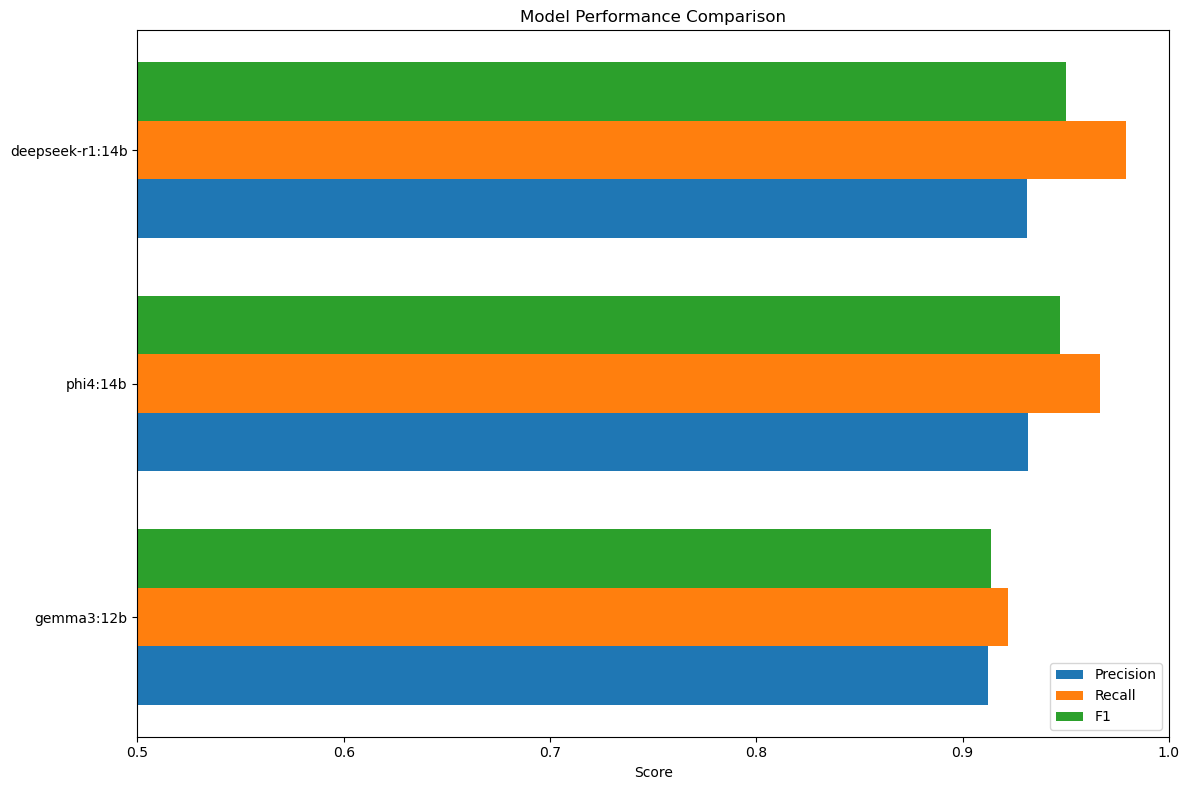

In [48]:
# Assuming your df is already loaded, reshape it
# Or if single column, reshape differently:
df_pivot = avg_results.reset_index()
df_pivot.columns = ['metric', 'model', 'value']
df_pivot = df_pivot.pivot(index='model', columns='metric', values='value')


# Filter out zero-performing models for cleaner visualization
df_plot = df_pivot[df_pivot['f1'] > 0].sort_values('f1', ascending=True)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(df_plot))
width = 0.25

ax.barh(x - width, df_plot['precision'], width, label='Precision')
ax.barh(x, df_plot['recall'], width, label='Recall')
ax.barh(x + width, df_plot['f1'], width, label='F1')

ax.set_yticks(x)
ax.set_yticklabels(df_plot.index)
ax.set_xlabel('Score')
ax.set_xlim(0.5, 1)
ax.legend()
ax.set_title('Model Performance Comparison')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

In [150]:

def create_f1_heatmap(results_df, output_path='f1_heatmap.png'):
    """
    Create a heatmap of F1 scores: models vs prompt strategies.
    """
    # Calculate mean F1 score for each model-prompt combination
    pivot_data = results_df.groupby(['model', 'prompt_strategy'])['f1'].mean().unstack()
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_data, 
        annot=True,  # Show F1 scores in cells
        fmt='.3f',   # 3 decimal places
        cmap='RdYlGn',  # Red-Yellow-Green colormap
        vmin=0, 
        vmax=1,
        cbar_kws={'label': 'F1 Score'}
    )
    
    plt.title('F1 Score Comparison: Models vs Prompt Strategies', fontsize=14, pad=20)
    plt.xlabel('Prompt Strategy', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Heatmap saved to {output_path}")
    return pivot_data


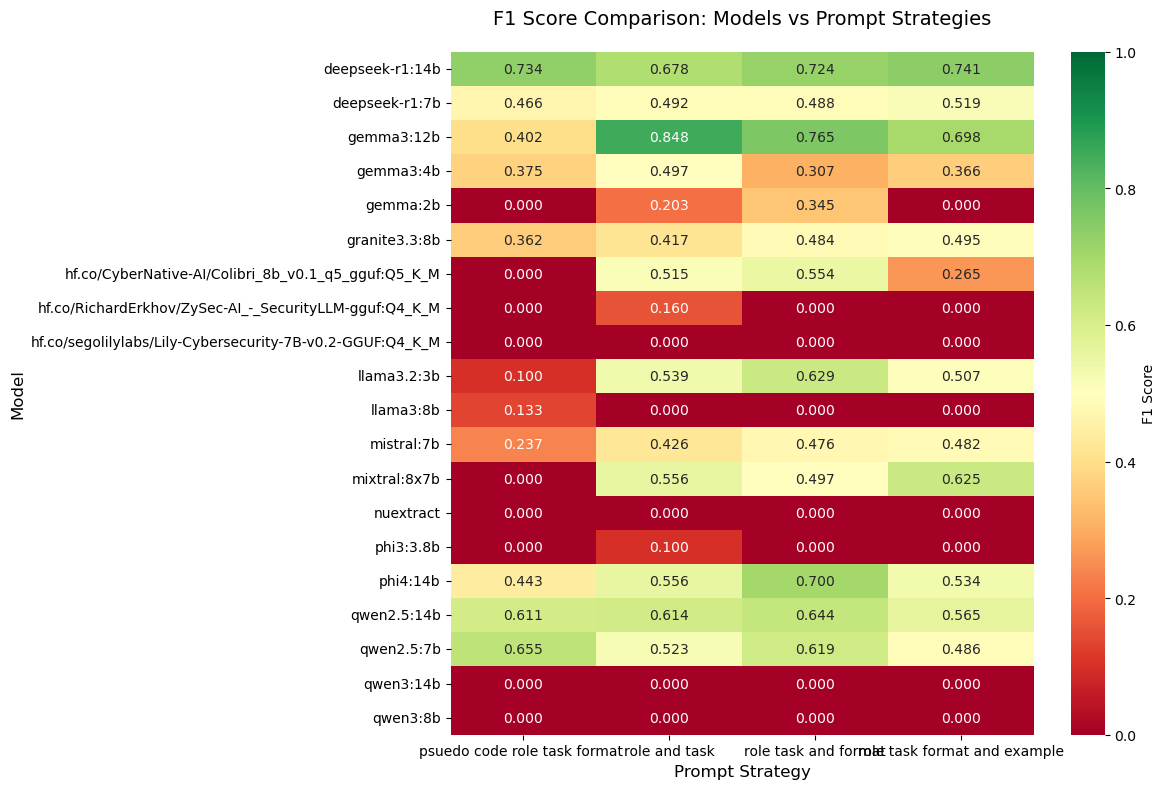


✓ Heatmap saved to f1_heatmap.png

Mean F1 Scores by Model and Prompt:
prompt_strategy                                            psuedo code role task format   \
model                                                                                      
deepseek-r1:14b                                                                 0.733912   
deepseek-r1:7b                                                                  0.465824   
gemma3:12b                                                                      0.401538   
gemma3:4b                                                                       0.374872   
gemma:2b                                                                        0.000000   
granite3.3:8b                                                                   0.361538   
hf.co/CyberNative-AI/Colibri_8b_v0.1_q5_gguf:Q5_K_M                             0.000000   
hf.co/RichardErkhov/ZySec-AI_-_SecurityLLM-gguf:Q4_K_M                          0.000000   
hf.co/se

In [158]:
pivot_table = create_f1_heatmap(llm_results)
print("\nMean F1 Scores by Model and Prompt:")
print(pivot_table)

In [181]:
pivot_data = llm_chunk_results.groupby(['model', 'delimiter'])['f1'].mean().unstack()
document_df = llm_results[llm_results['prompt_strategy'] == 'role task and format'].groupby(['model'])['f1'].mean()
pivot_data['document'] = document_df.loc[pivot_data.index]
pivot_data = pivot_data.rename(columns={'\n': 'paragraph', '. ': 'sentence'})

delimiter,paragraph,sentence,document
model,,,
deepseek-r1:14b,0.549573,0.800615,0.724286
deepseek-r1:7b,0.597134,0.704740,0.488205
gemma3:12b,0.722278,0.745088,0.765368
gemma3:4b,0.263266,0.495458,0.307143
gemma:2b,0.077675,0.081711,0.345455
llama3.2:3b,0.495238,0.385330,0.628571
phi3:3.8b,0.033333,0.000000,0.000000


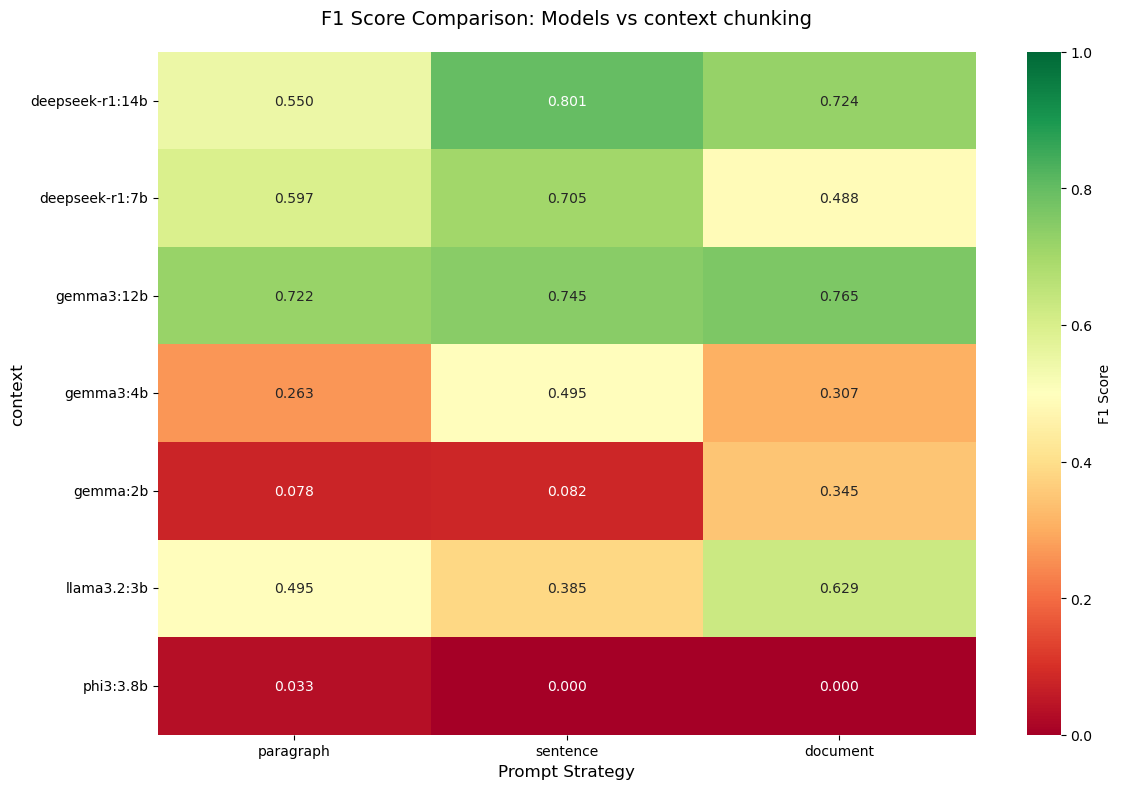

delimiter,paragraph,sentence,document
model,,,
deepseek-r1:14b,0.549573,0.800615,0.724286
deepseek-r1:7b,0.597134,0.704740,0.488205
gemma3:12b,0.722278,0.745088,0.765368
gemma3:4b,0.263266,0.495458,0.307143
gemma:2b,0.077675,0.081711,0.345455
llama3.2:3b,0.495238,0.385330,0.628571
phi3:3.8b,0.033333,0.000000,0.000000


In [184]:

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    annot=True,  # Show F1 scores in cells
    fmt='.3f',   # 3 decimal places
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    vmin=0, 
    vmax=1,
    cbar_kws={'label': 'F1 Score'}
)
    
plt.title('F1 Score Comparison: Models vs context chunking', fontsize=14, pad=20)
plt.xlabel('Prompt Strategy', fontsize=12)
plt.ylabel('context', fontsize=12)
plt.tight_layout()
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
    

pivot_data

In [161]:

successful = llm_results[llm_results['success'] == True]

print(f"=== LLM Experiment Summary ===")
print(f"Success rate: {len(successful)/len(llm_results)*100:.1f}% ({len(successful)}/{len(llm_results)})")

# Aggregate by model
model_avg = successful.groupby('model').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'elapsed_time': 'mean'
}).round(3)
best_model = model_avg['f1'].idxmax()

dataset['llm_metrics'] = list(model_avg[model_avg.index == best_model].to_dict('index').values())[0]


print("\n=== Average Performance by Model ===")
print(model_avg.sort_values('f1', ascending=False))

# Aggregate by prompt strategy
prompt_avg = successful.groupby('prompt_strategy').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'elapsed_time': 'mean'
}).round(3)

print("\n=== Average Performance by Prompt Strategy ===")
print(prompt_avg.sort_values('f1', ascending=False))

# Best overall result
best_result = successful.loc[successful['f1'].idxmax()]
print("\n=== Best Result ===")
print(f"Model: {best_result['model']}")
print(f"Prompt: {best_result['prompt_strategy']}")
print(f"F1: {best_result['f1']:.3f}")
print(f"Precision: {best_result['precision']:.3f}")
print(f"Recall: {best_result['recall']:.3f}")
print(f"Time: {best_result['elapsed_time']:.2f}s")

=== LLM Experiment Summary ===
Success rate: 100.0% (400/400)

=== Average Performance by Model ===
                                                           precision  recall  \
model                                                                          
deepseek-r1:14b                                                0.967   0.589   
gemma3:12b                                                     0.843   0.600   
qwen2.5:14b                                                    0.932   0.492   
qwen2.5:7b                                                     0.800   0.461   
phi4:14b                                                       0.814   0.457   
deepseek-r1:7b                                                 0.808   0.370   
llama3.2:3b                                                    0.642   0.352   
granite3.3:8b                                                  0.800   0.312   
mixtral:8x7b                                                   0.529   0.353   
mistral:7b          

In [49]:
# Figure 3: LLM Model Performance (if LLM experiments were run)
if 'successful' in locals() and len(successful) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    model_avg_sorted = model_avg.sort_values('f1', ascending=True)
    
    y_pos = np.arange(len(model_avg_sorted))
    ax.barh(y_pos, model_avg_sorted['f1'], color='steelblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_avg_sorted.index)
    ax.set_xlabel('F1-Score')
    ax.set_title('LLM Model base Performance Comparison')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(model_avg_sorted['f1']):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.savefig('llm_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: llm_model_comparison.png")

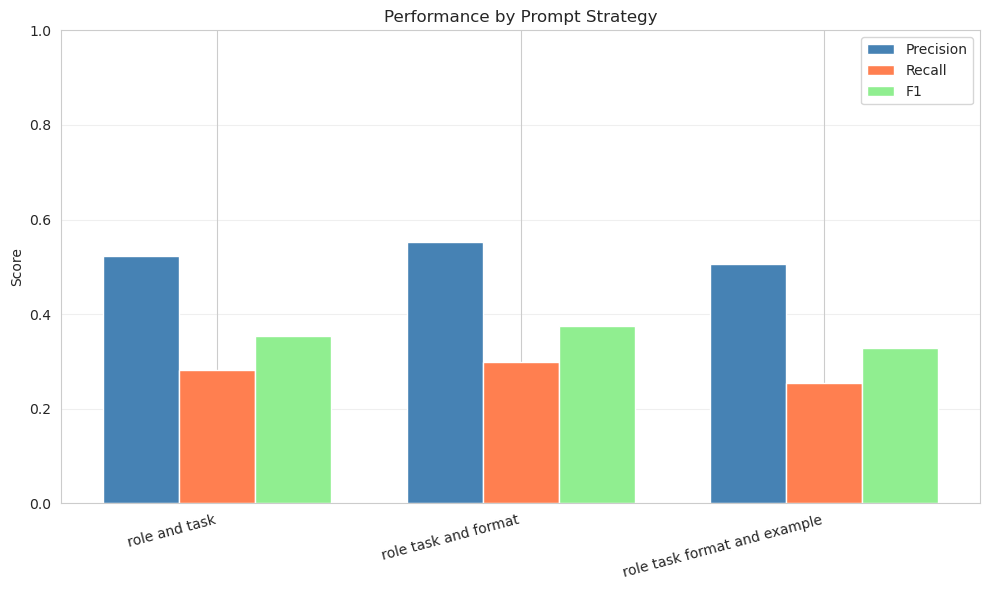

✓ Saved: prompt_strategy_comparison.png


In [51]:
# Figure 4: Prompt Strategy Performance (if LLM experiments were run)
if 'successful' in locals() and len(successful) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    prompt_names = prompt_avg.index
    x = np.arange(len(prompt_names))
    width = 0.25
    
    ax.bar(x - width, prompt_avg['precision'], width, label='Precision', color='steelblue')
    ax.bar(x, prompt_avg['recall'], width, label='Recall', color='coral')
    ax.bar(x + width, prompt_avg['f1'], width, label='F1', color='lightgreen')
    
    ax.set_ylabel('Score')
    ax.set_title('Performance by Prompt Strategy')
    ax.set_xticks(x)
    ax.set_xticklabels(prompt_names, rotation=15, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prompt_strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: prompt_strategy_comparison.png")